# Self-Generative Systems (SGS) with an integrated Large Language Model (LLM). 

# 集成大型语言模型（LLM）的自生成系统（SGS）

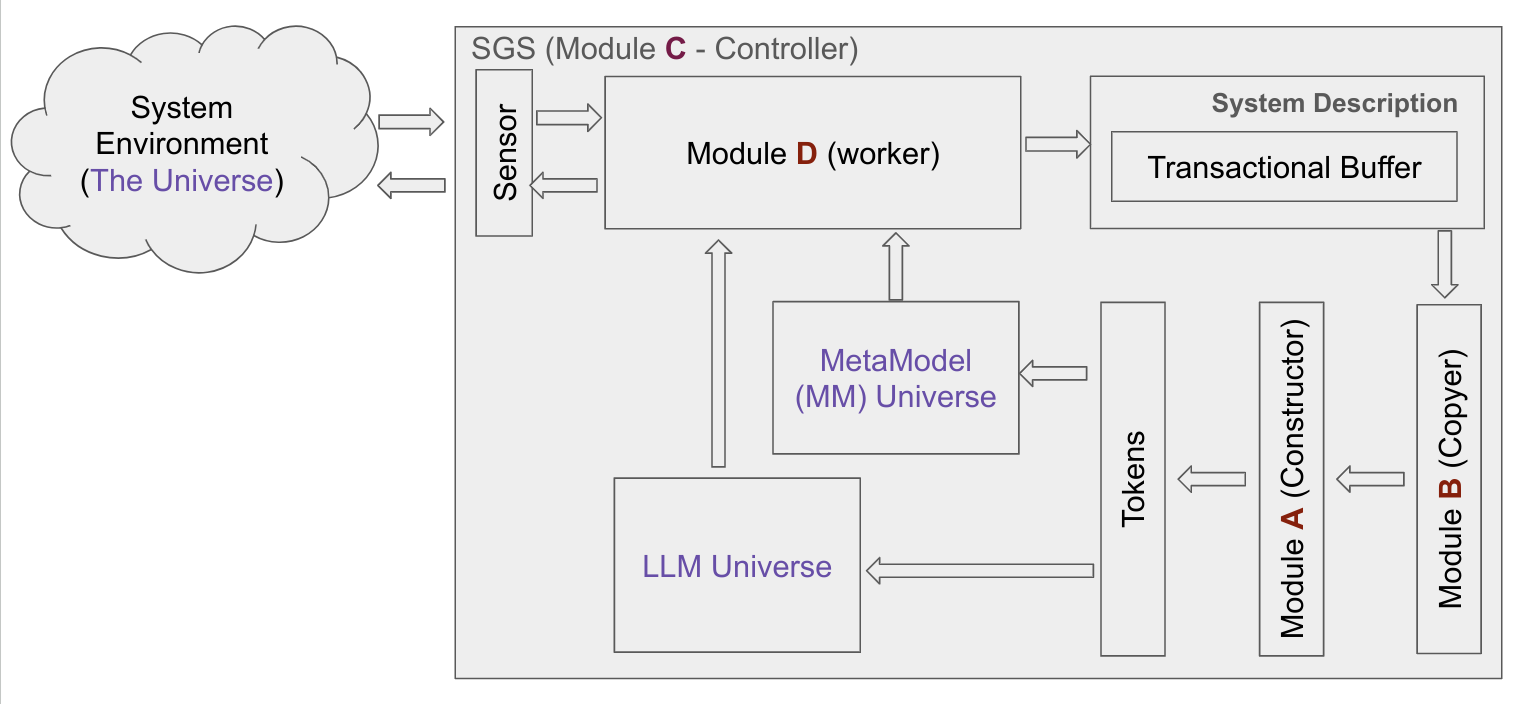

在本次演示中，我们将深入探讨一种智能且无缝的方式，将人工智能模型，尤其是大型语言模型（LLMs），集成到SGS框架中，而无需任何麻烦。这种集成的一个突出特点是共享的标记化过程，它将数据输入到元数据模型（MM）和LLMs中。通过为这两个组件使用相同的基础数据，我们提升了系统性能，并保持一切运行流畅且一致。

为了实现这一点，我们对所选的LLM——GPT2Tokenizer进行了标记器的增强。

在ExtendedGPT2Tokenizer中，我们有两个主要方法来处理这个问题：

- **`tokenize_text(text)`**：此方法负责将输入文本拆分为标记。
- **`update_tensors(token_ids)`**：此方法根据这些标记ID更新存储元模型HllSets数据的张量。

通过这些改进，我们为更高效的集成做好了准备！



In [1]:
using PyCall
using DataFrames

# Import the fine_tune_model and parse_decoded_strings functions from the Python script
py"""
import sys
sys.path.append(".")
from SGS_Tokenizer import ExtendedGPT2Tokenizer, GPT2Tokenizer, GPT2LMHeadModel
"""

function tensor_to_array(tensor::PyObject)
    # Convert PyObject to Julia Vector{UInt32}
    hllset_array = pycall(tensor.numpy, PyArray)
    hllset_vector = Vector{Int64}(hllset_array)

    return hllset_vector
end

tensor_to_array (generic function with 1 method)


### 张量更新过程

1. 获取令牌ID：
```python
token_ids = tokenizer.tokenize_text(text)
```

2. 更新张量：
```python
new_tensor_1, double_value = tokenizer.update_tensors(token_ids)
```

这种简化的方法确保AI模型在SGS框架中的集成既无缝又有效。

In [2]:
text = "When the distance between two unit-length vectors is defined to be the length of their vector difference then"

vocab_file = "JLD2/vocab.json"      # Path to the vocab file
merges_file = "JLD2/merges.txt"     # Path to the merges file

tokenizer = py"ExtendedGPT2Tokenizer"(vocab_file, merges_file, p=4)

# text = "When the distance between two unit-length vectors is defined to be the length of their vector difference then"

# Update tensors
token_ids = tokenizer.tokenize_text(text)
new_tensor_1, double_value = tokenizer.update_tensors(token_ids)

# println("new_tensor_1:", new_tensor_1)
# println("double_value:", double_value)

id, sha1, hll_tensor = tokenizer.tensor_to_hlltensor(new_tensor_1)
println("HLLSet:", id, "; ", sha1, "; ", hll_tensor)

hll_vector = tensor_to_array(hll_tensor)

# println("HLLSet (Vector{Int64}):", hll_vector)

tensor_slice = tokenizer.hlltensor_to_tensor(hll_tensor)
println("Tensor Slice:", tensor_slice)

# tokenizer.print_tensor_1(tensor=tokenizer.tensor_1)

HLLSet:1; 4da9de3e80bcb65ee6169a411b0206ce45ba68bc; PyObject tensor([ 2, 18, 12,  2,  2, 28,  0,  8,  0, 22,  0,  0,  0,  2,  0,  2])
Tensor Slice:PyObject tensor([[1.0220e+03, 4.0546e+07, 1.0000e-01],
        [1.2000e+01, 1.6594e+08, 1.0000e-01],
        [7.3400e+02, 3.3153e+08, 1.1000e+00],
        [3.0104e+04, 5.2051e+08, 1.1000e+00],
        [5.1100e+02, 4.0169e+08, 1.1000e+00],
        [2.6200e+02, 3.9209e+08, 1.4000e+00],
        [2.6200e+02, 3.9209e+08, 1.4000e+00],
        [3.1800e+02, 5.7578e+08, 2.2000e+00],
        [3.5800e+03, 6.3241e+08, 2.3000e+00],
        [7.8800e+02, 9.3641e+08, 3.1000e+00],
        [4.1290e+03, 1.1767e+09, 4.1000e+00],
        [2.8400e+02, 1.3680e+09, 5.2000e+00],
        [4.3260e+03, 1.4954e+09, 5.3000e+00],
        [1.5879e+04, 1.5664e+09, 5.4000e+00],
        [3.0700e+02, 1.8849e+09, 7.3000e+00],
        [5.2530e+03, 2.4650e+09, 9.1000e+00],
        [1.3664e+04, 2.6029e+09, 9.2000e+00],
        [5.4470e+03, 2.5253e+09, 9.4000e+00],
        [2.2150e

In [3]:
tokenizer.print_tensors()

此时，我们已成功将文本集成到大型语言模型（LLM）和元数据模型（MM）中，使我们能够访问这两个模型的标记以进行搜索和检索。

要从MM中提取与查询相关的所有HllSets，我们这样做：

1. 首先，我们基于查询文本创建一个HllSet，使用与之前相同的标记化过程。
2. 接下来，我们在MM中搜索所有与查询HllSet相似的HllSets。我们使用余弦相似度来找出那些达到特定阈值的HllSets。
3. 最后，我们使用标记哈希到标记ID的映射，通过识别出的标记ID查询LLM。我们得到的标记将形成一个相关标记的集合。

通过遵循这些步骤，我们确保了相关标记的高效检索！

提醒一下：在这种情况下，元数据模型并不关心令牌；它们由LLM处理。


In [4]:
# Perform search
query = "When the distance between two unit-length vectors is defined"

threshold = 0.1
related_hllsets = pycall(tokenizer.search, PyObject, query, threshold)
println("Related HLL sets: ", related_hllsets)

# Get related tokens
related_tokens = pycall(tokenizer.get_related_tokens, PyObject, related_hllsets)
# println("Related tokens: ", related_tokens)

Related HLL sets: PyObject [0]


PyObject [' between', '-', ' two', ' vectors', ' their', ' the', ' the', ' is', ' difference', ' then', ' length', ' to', ' unit', ' vector', ' be', ' distance', 'length', ' defined', 'When', ' of']

我们现在可以请求LLM提供与提取的相关令牌一致的建议。

In [5]:
# Generate meaningful text
suggestions = []
try    
    suggestions = pycall(tokenizer.generate_text, PyObject, related_tokens, 3)
catch e
    println("Error generating text suggestions: ", e)
end


println(tokenizer.format_generated_texts(suggestions))

# tokenizer.print_tensors()


Generated text suggestions:
Suggestion 1:
-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character (disambiguation).

Suggestion 2:
-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character (disambiguation)

Suggestion 3:
-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character.

"I'm


我们假设元模型中的HllSets以某种方式组织。一个常见的组织方法是使用余弦相似度等技术将HllSets分组到相关社区中。这使我们能够评估生成的建议，并根据我们的兴趣选择最相关的建议。

In [6]:
# Evaluate generated texts
communities = [
    
    "4da9de3e80bcb65ee6169a411b0206ce45ba68bc"
    ]  # Load or define your communities of HLL sets here

evaluation_results = pycall(tokenizer.evaluate_generated_texts, PyObject, suggestions, communities)
println("Evaluation results: ", tokenizer.format_generated_texts(evaluation_results))

Evaluation results: 
Generated text suggestions:
Suggestion 1:
('-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character (disambiguation).', '4da9de3e80bcb65ee6169a411b0206ce45ba68bc', np.float64(0.21087891921820445))

Suggestion 2:
('-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character (disambiguation)', '4da9de3e80bcb65ee6169a411b0206ce45ba68bc', np.float64(0.2988664113443373))

Suggestion 3:
('-lengthWhenThis article is about a character, it is not about them. For other uses of the term "character", see Character.\n\n"I\'m', '4da9de3e80bcb65ee6169a411b0206ce45ba68bc', np.float64(0.29280576695787364))
